**Research Question 3: SUHII Distribution**
**Purpose of the Analysis**
The objective of this section is to:

1. Quantify SUHII intensity across the urban–rural gradient.
2. Compare daytime and nighttime SUHII patterns.
3. Examine spatial heterogeneity of thermal hotspots.
4. Examine the SUHII distribution by Local Climate Zones (LCZ) and Local Government Areas (LGAs)

T**How can the background rural reference area be objectively defined to ensure robust SUHII estimation?**
This question focuses on establishing a consistent and reproducible definition of the rural baseline against which urban temperatures are compared.
How urban heat decays across kilometers

**How does SUHII vary spatially across Local Climate Zones (LCZs) and Local Government Areas (LGAs) during daytime and nighttime conditions?**
This question examines how SUHII intensity differs across urban morphological classes and administrative boundaries under diurnal conditions.

**How does the diurnal cycle of LST influence the magnitude and spatial pattern of SUHII?**
This question explores how daytime heating and nighttime cooling dynamics shape the intensity and spatial structure of SUHII.

**Data Source**
To analyse the Surface Urban Heat Island Intensity (SUHII) distribution, we used STARFM-fused Land Surface Temperature (LST) images representing full diurnal conditions.

The fused datasets include:
- **Daytime LST (30 m resolution)** : Landsat-based STARFM fused images
- **Nighttime LST (70 m resolution)** : ECOSTRESS-based STARFM fused images

**Selected Study Dates**
The following dates were selected to represent warm-season conditions with varying atmospheric and thermal characteristics:
- 3 December 2022  
- 27 December 2022  
- 7 January 2023  
- 27 January 2023  

These dates allow assessment of both daytime and nighttime SUHII spatial distribution under different synoptic and thermal environments. The high spatial resolution of the fused LST images (30 m daytime, 70 m nighttime) enables fine-scale analysis of intra-urban thermal variability.

# 1. Definition of the Background Rural Area (BRA) and calculation of SUHII
The Background Rural Area (BRA) is defined as the area adjacent to the urban core that represents non-urban thermal conditions.

In terms of Local Climate Zones (LCZ), the BRA corresponds to **LCZ D (Low Plants)** as defined by Stewart and Oke (2012). LCZ D is characterized by open, low vegetation cover, typically consisting of grasslands or agricultural fields with minimal built structures.

For the case of Melbourne, the BRA is operationally delineated using the Urban Growth Boundary (UGB). The UGB defines the limit of urban expansion and separates built-up areas from protected non-urban land.

![UGB](../data/jpeg/ugb.jpg)
![Urban Area](../data/jpeg/ugb_urban_areas.jpg)
![DEASE Method](../data/jpeg/dease.jpg)



## 1.1 Direction-enhanced adaptive synchronous extraction (DEASE)

The Direction-Enhanced Adaptive Synchronous Extraction (DEASE) method is applied to define the Background Rural Area (BRA), following the framework proposed by Yang et al. (2026). This method enables direction-specific extraction of rural reference temperatures, ensuring adaptive and spatially consistent SUHII estimation.

The procedure consists of three main steps:

**(1) Construction and Division of Directional Buffers** 

The urban center is used as the reference point.  
From this center, multiple directional transects (bearings) are generated, and concentric buffers are constructed along each direction.

Each direction is treated independently to capture anisotropic thermal patterns.  
This step allows characterization of temperature gradients along the urban–rural continuum.

**(2) Detection of Turning Points Along Each Bearing**
For each directional profile, the Land Surface Temperature (LST) gradient is analyzed from the urban core outward.

A turning point is identified where:
- The LST gradient stabilizes or changes trend (inflection point), and  
- The temperature pattern transitions from urban-influenced to rural background conditions.

This adaptive detection ensures that the rural reference is not arbitrarily fixed but dynamically determined for each direction.

**(3) Calculation of SUHII**

Once the Background Rural Area (BRA) is identified for each direction, the Surface Urban Heat Island Intensity (SUHII) is calculated as:

$SUHII = LST_{urban} - LST_{BRA}$

where:

- $LST_{urban}$ represents the mean urban temperature,
- $LST_{BRA}$ represents the direction-specific rural reference temperature.

This directional approach reduces bias caused by heterogeneous land cover and varying thermal landscapes surrounding the city.

### 1.1.1 Detection of Turning Points Along Each Bearing

In [2]:
# Import necessary libraries
import sys
import pandas as pd
from pygam import LinearGAM, s
import numpy as np
import matplotlib.pyplot as plt

print(sys.executable)
print(pd.__version__)


c:\Users\percy\Documents\studies\visual_studio_code\PhD-chapter3-SUHII\.venv\Scripts\python.exe
1.3.5


In [3]:
# Load the gradient metadata from the CSV file
gradient_metadata = pd.read_csv(r"C:\Users\percy\Documents\studies\visual_studio_code\PhD-chapter3-SUHII\data\csv\ring_buffer_metadata_csv.csv")

# View the first 5 rows of the gradient metadata
print(gradient_metadata.head())

   direction  distance  buffer_no  buffer_id        area
0        315       6.5         13          1  762.786613
1        315       7.0         14          2  811.605721
2        315       8.0         16          3  807.433170
3        315       8.5         17          4  776.949262
4        315       9.0         18          5  780.087086


In [4]:
# Load the mean day_lst data from the CSV file
day_lst = pd.read_csv(r"C:\Users\percy\Documents\studies\visual_studio_code\PhD-chapter3-SUHII\data\csv\day_lst_mean_zonal_csv.csv")

# create lst_mean as a copy of MEAN
day_lst['lst_mean'] = day_lst['MEAN']

# View the first 5 rows
print(day_lst.head())

   buffer_id   COUNT       AREA       MEAN   lst_mean
0          1  8483.0  7634700.0  35.274751  35.274751
1          2  8985.0  8086500.0  35.649215  35.649215
2          3  8976.0  8078400.0  35.543542  35.543542
3          4  8617.0  7755300.0  36.188831  36.188831
4          5  8676.0  7808400.0  35.946821  35.946821


In [5]:
# Join the day_lst DataFrame with the gradient metadata DataFrame on the buffer_id column
day_lst_gradient = pd.merge(day_lst, gradient_metadata, on='buffer_id')

# LST for Urban areas (distance = 0) is missing for some directions. We will fill in those missing values by taking the mean of the first 3 buffer zones (buffer_id <= 3) for each direction and assigning that mean to the lst_mean column for buffer_id <= 3.
# 1️⃣ Select rows where buffer_id == 1000
rows_1000 = day_lst_gradient[day_lst_gradient["buffer_id"] == 1000]

# 2️⃣ Directions you want to create
new_directions = [15, 45, 315, 285, 255]

# 3️⃣ Create modified copies
copies = []
for d in new_directions:
    temp = rows_1000.copy()
    temp["direction"] = d
    copies.append(temp)

# 4️⃣ Concatenate all copies
new_rows = pd.concat(copies, ignore_index=True)

# 5️⃣ (Optional) Append back to original dataframe
day_lst_gradient = pd.concat([day_lst_gradient, new_rows], ignore_index=True)

# Keep only desired columns
day_lst_gradient = day_lst_gradient[["buffer_id", "buffer_no", "distance", "direction", "lst_mean"]]

# Keep only desired columns
day_lst_gradient = day_lst_gradient[["buffer_id", "buffer_no", "distance", "direction", "lst_mean"]]

# View the first 5 rows of the joined DataFrame
print(day_lst_gradient.head(10))

# save the joined DataFrame to a new CSV file
#day_lst_gradient.to_csv(r"C:\Users\percy\Documents\studies\visual_studio_code\PhD-chapter3-SUHII\data\csv\day_lst_gradient_csv.csv", index=False)

   buffer_id  buffer_no  distance  direction   lst_mean
0          1         13       6.5        315  35.274751
1          2         14       7.0        315  35.649215
2          3         16       8.0        315  35.543542
3          4         17       8.5        315  36.188831
4          5         18       9.0        315  35.946821
5          6         19       9.5        315  36.245463
6          7         20      10.0        315  36.454228
7          8         21      10.5        315  36.178197
8          9         22      11.0        315  35.894562
9         10         23      11.5        315  35.852690


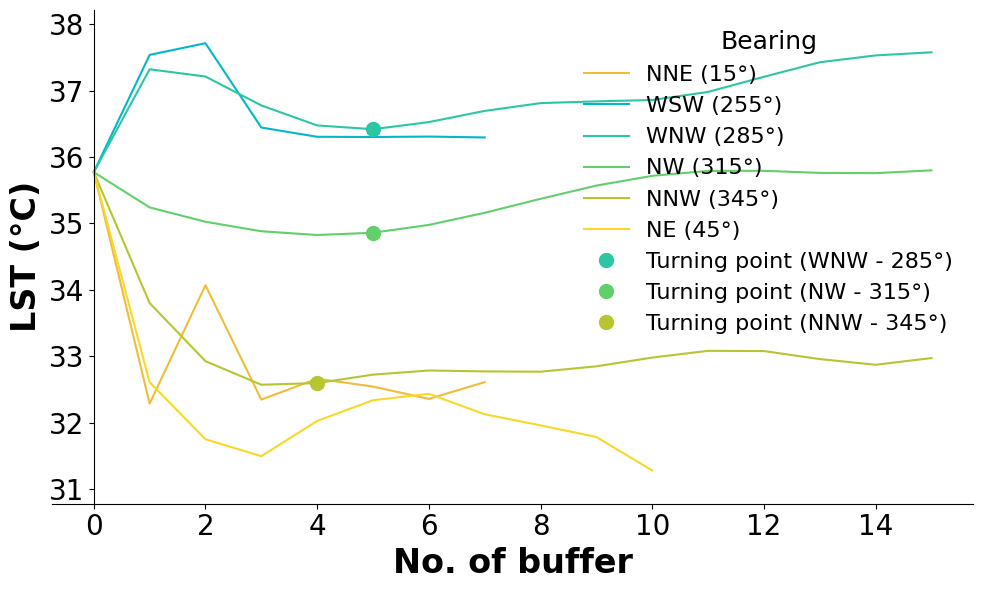

In [6]:
day_spline_results = []

for direction, group in day_lst_gradient.groupby("direction"):
    group = group.sort_values("buffer_no")
    
    X = group["buffer_no"].values.reshape(-1, 1)
    y = group["lst_mean"].values
    
    # Fit cubic smoothing spline
    gam = LinearGAM(s(0, spline_order=3)).fit(X, y)
    pred = gam.predict(X)
    
    # If buffer_no == 0 exists, replace spline prediction with actual value
    idx0 = np.where(group["buffer_no"].values == 0)[0]
    if len(idx0) == 1:
        pred[idx0[0]] = group["lst_mean"].values[idx0[0]]
    
    # Store results
    temp_df = pd.DataFrame({
        "buffer_no": group["buffer_no"].values,
        "lst_mean": pred,
        "direction": direction
    })
    
    day_spline_results.append(temp_df)

# Combine all directions
day_spline_df = pd.concat(day_spline_results, ignore_index=True)
day_spline_df = day_spline_df[day_spline_df["buffer_no"] <= 15]

# -------------------
# Plot curves as before
# -------------------

# Ensure direction is a string and clean
day_spline_df["direction"] = day_spline_df["direction"].astype(str).str.strip()

# Updated color dictionary 
colors = {
    "255": "#03b6ca",
    "285": "#2cc6a4",
    "315": "#63cf6c",
    "345": "#b7c532",
    "15":  "#f1bc3a",
    "45":  "#f8d82b"
}

# Optional: legend labels (clean compass names)
legend_labels = {
    "255": "WSW (255°)",
    "285": "WNW (285°)",
    "315": "NW (315°)",
    "345": "NNW (345°)",
    "15":  "NNE (15°)",
    "45":  "NE (45°)"
}

plt.figure(figsize=(10, 6))
ax = plt.gca()

for direction, group in day_spline_df.groupby("direction"):
    ax.plot(
        group["buffer_no"],
        group["lst_mean"],
        linewidth=1.5,
        color=colors.get(direction, "black"),
        label=legend_labels.get(direction, direction)
    )

# Optional: add red dot at buffer_no=5 for NNW
wnw = day_spline_df[day_spline_df["direction"] == "285"]
inflect_row = wnw[wnw["buffer_no"] == 5]
if not inflect_row.empty:
    x_inflect = inflect_row["buffer_no"].values[0]
    y_inflect = inflect_row["lst_mean"].values[0]
    ax.plot(x_inflect, y_inflect, 'o', color=colors["285"], markersize=10, label="Turning point (WNW - 285°)")

nw = day_spline_df[day_spline_df["direction"] == "315"]
inflect_row = nw[nw["buffer_no"] == 5]
if not inflect_row.empty:
    x_inflect = inflect_row["buffer_no"].values[0]
    y_inflect = inflect_row["lst_mean"].values[0]
    ax.plot(x_inflect, y_inflect, 'o', color=colors["315"], markersize=10, label="Turning point (NW - 315°)")

nnw = day_spline_df[day_spline_df["direction"] == "345"]
inflect_row = nnw[nnw["buffer_no"] == 4]
if not inflect_row.empty:
    x_inflect = inflect_row["buffer_no"].values[0]
    y_inflect = inflect_row["lst_mean"].values[0]
    ax.plot(x_inflect, y_inflect, 'o', color=colors["345"], markersize=10, label="Turning point (NNW - 345°)")


# Axis formatting
ax.set_xlabel("No. of buffer", fontsize=24, fontweight="bold")
ax.set_ylabel("LST (°C)", fontsize=24, fontweight="bold")
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)


# Disable all grid lines
ax.grid(False)

# -----------------------
# Set y-axis start at the vertical line x=0
# -----------------------
ax.spines["left"].set_position(("data", 0))    # left spine (y-axis) at x=0
ax.spines["bottom"].set_position(("outward", 0))
ax.spines["top"].set_color("none")
ax.spines["right"].set_color("none")
y_min = day_spline_df["lst_mean"].min() - 0.5
y_max = day_spline_df["lst_mean"].max() + 0.5 
ax.set_ylim(y_min, y_max)

# Legend
ax.legend(title="Bearing", title_fontsize=18, fontsize=16, frameon=False, loc="upper right")

plt.tight_layout()
plt.show()

In [ ]:
# Nighttime

# Load the mean day_lst data from the CSV file
night_lst = pd.read_csv(r"C:\Users\percy\Documents\studies\visual_studio_code\PhD-chapter3-SUHII\data\csv\night_lst_mean_zonal_csv.csv")

# create lst_mean as a copy of MEAN
night_lst['lst_mean'] = night_lst['MEAN']

# Check result
print(night_lst.tail())


     buffer_id     COUNT          AREA       MEAN   lst_mean
105        109     838.0  4.106200e+06  18.559923  18.559923
106        110     728.0  3.567200e+06  18.543326  18.543326
107        111     455.0  2.229500e+06  18.400142  18.400142
108        112      27.0  1.323000e+05  18.408130  18.408130
109       1000  248818.0  1.219208e+09  21.209817  21.209817


In [79]:
# Join the night_lst DataFrame with the gradient metadata DataFrame on the buffer_id column
night_lst_gradient = pd.merge(night_lst, gradient_metadata, on='buffer_id')

# LST for Urban areas (distance = 0) is missing for some directions. We will fill in those missing values by taking the mean of the first 3 buffer zones (buffer_id <= 3) for each direction and assigning that mean to the lst_mean column for buffer_id <= 3.
# 1️⃣ Select rows where buffer_id == 1000
rows_1000 = night_lst_gradient[night_lst_gradient["buffer_id"] == 1000]

# 2️⃣ Directions you want to create
new_directions = [15, 45, 315, 285, 255]

# 3️⃣ Create modified copies
copies = []
for d in new_directions:
    temp = rows_1000.copy()
    temp["direction"] = d
    copies.append(temp)

# 4️⃣ Concatenate all copies
new_rows = pd.concat(copies, ignore_index=True)

# 5️⃣ (Optional) Append back to original dataframe
night_lst_gradient = pd.concat([night_lst_gradient, new_rows], ignore_index=True)

# Keep only desired columns
night_lst_gradient = night_lst_gradient[["buffer_id", "buffer_no", "distance", "direction", "lst_mean"]]

# View the first 5 rows of the joined DataFrame
print(night_lst_gradient.head(10))

# save the joined DataFrame to a new CSV file
#night_lst_gradient.to_csv(r"C:\Users\percy\Documents\studies\visual_studio_code\PhD-chapter3-SUHII\data\csv\night_lst_gradient_csv.csv", index=False)

   buffer_id  buffer_no  distance  direction   lst_mean
0          1         13       6.5        315  18.040423
1          2         14       7.0        315  18.108813
2          3         16       8.0        315  18.025067
3          4         17       8.5        315  18.279786
4          5         18       9.0        315  18.285922
5          6         19       9.5        315  18.292840
6          7         20      10.0        315  18.499342
7          8         21      10.5        315  18.574320
8          9         22      11.0        315  18.382351
9         10         23      11.5        315  18.539594


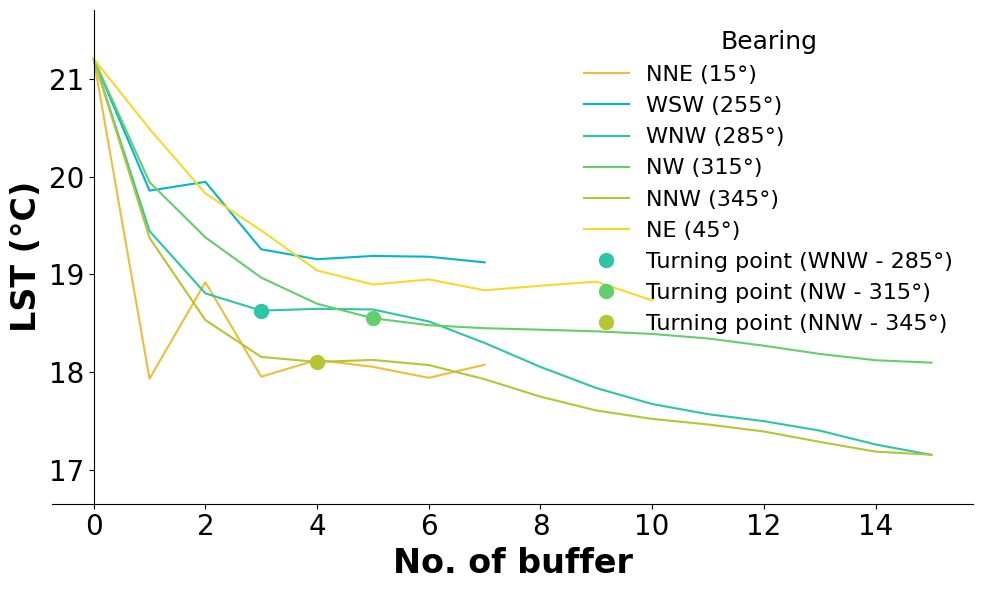

In [85]:
night_spline_results = []

for direction, group in night_lst_gradient.groupby("direction"):
    group = group.sort_values("buffer_no")
    
    X = group["buffer_no"].values.reshape(-1, 1)
    y = group["lst_mean"].values
    
    # Fit cubic smoothing spline
    gam = LinearGAM(s(0, spline_order=3)).fit(X, y)
    pred = gam.predict(X)
    
    # If buffer_no == 0 exists, replace spline prediction with actual value
    idx0 = np.where(group["buffer_no"].values == 0)[0]
    if len(idx0) == 1:
        pred[idx0[0]] = group["lst_mean"].values[idx0[0]]
    
    # Store results
    temp_df = pd.DataFrame({
        "buffer_no": group["buffer_no"].values,
        "lst_mean": pred,
        "direction": direction
    })
    
    night_spline_results.append(temp_df)

# Combine all directions
night_spline_df = pd.concat(night_spline_results, ignore_index=True)
night_spline_df = night_spline_df[night_spline_df["buffer_no"] <= 15]

# -------------------
# Plot curves as before
# -------------------

# Ensure direction is a string and clean
night_spline_df["direction"] = night_spline_df["direction"].astype(str).str.strip()

# Updated color dictionary 
colors = {
    "255": "#03b6ca",
    "285": "#2cc6a4",
    "315": "#63cf6c",
    "345": "#b7c532",
    "15":  "#f1bc3a",
    "45":  "#f8d82b"
}

# Optional: legend labels (clean compass names)
legend_labels = {
    "255": "WSW (255°)",
    "285": "WNW (285°)",
    "315": "NW (315°)",
    "345": "NNW (345°)",
    "15":  "NNE (15°)",
    "45":  "NE (45°)"
}

plt.figure(figsize=(10, 6))
ax = plt.gca()

for direction, group in night_spline_df.groupby("direction"):
    ax.plot(
        group["buffer_no"],
        group["lst_mean"],
        linewidth=1.5,
        color=colors.get(direction, "black"),
        label=legend_labels.get(direction, direction)
    )

# Optional: add red dot at buffer_no=5 for NNW
wnw = night_spline_df[night_spline_df["direction"] == "285"]
inflect_row = wnw[wnw["buffer_no"] == 3]
if not inflect_row.empty:
    x_inflect = inflect_row["buffer_no"].values[0]
    y_inflect = inflect_row["lst_mean"].values[0]
    ax.plot(x_inflect, y_inflect, 'o', color=colors["285"], markersize=10, label="Turning point (WNW - 285°)")

nw = night_spline_df[night_spline_df["direction"] == "315"]
inflect_row = nw[nw["buffer_no"] == 5]
if not inflect_row.empty:
    x_inflect = inflect_row["buffer_no"].values[0]
    y_inflect = inflect_row["lst_mean"].values[0]
    ax.plot(x_inflect, y_inflect, 'o', color=colors["315"], markersize=10, label="Turning point (NW - 315°)")

nnw = night_spline_df[night_spline_df["direction"] == "345"]
inflect_row = nnw[nnw["buffer_no"] == 4]
if not inflect_row.empty:
    x_inflect = inflect_row["buffer_no"].values[0]
    y_inflect = inflect_row["lst_mean"].values[0]
    ax.plot(x_inflect, y_inflect, 'o', color=colors["345"], markersize=10, label="Turning point (NNW - 345°)")


# Axis formatting
ax.set_xlabel("No. of buffer", fontsize=24, fontweight="bold")
ax.set_ylabel("LST (°C)", fontsize=24, fontweight="bold")
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)


# Disable all grid lines
ax.grid(False)

# -----------------------
# Set y-axis start at the vertical line x=0
# -----------------------
ax.spines["left"].set_position(("data", 0))    # left spine (y-axis) at x=0
ax.spines["bottom"].set_position(("outward", 0))
ax.spines["top"].set_color("none")
ax.spines["right"].set_color("none")
y_min = night_spline_df["lst_mean"].min() - 0.5
y_max = night_spline_df["lst_mean"].max() + 0.5 
ax.set_ylim(y_min, y_max)

# Legend
ax.legend(title="Bearing", title_fontsize=18, fontsize=16, frameon=False, loc="upper right")

plt.tight_layout()
plt.show()

# 2.Spatial Distribution of SUHII

# 3. Diurnal Dynamics of SUHII